In [1]:
from dptb.nn.build import build_model
from dptb.postprocess.bandstructure.band import Band
import  matplotlib.pyplot  as plt
import numpy as np
from ase.io import read
from dptb.data import AtomicData, AtomicDataDict
from dptb.nn.nnsk import NNSK
import json
import torch

In [2]:
# The settings for the model. must be provided.
model = NNSK.from_reference(checkpoint= "./outv2spd/nrl_ckpt.json")
#model = NNSK.from_reference(checkpoint= "./nrlspd_frzoverlap/checkpoint/nnsk.best.pth")


In [20]:
model2 = NNSK.from_reference(checkpoint= "/Users/aisiqg/Desktop/work/github/DeePTB/dptb/tests/data/test_sktb/output/test_nrl/checkpoint/nnsk.best.pth")


In [21]:
model.hopping_param - model2.hopping_param

tensor([[[ 1.0010e-02,  1.0010e-02,  1.0010e-02,  1.0000e-02],
         [-9.9945e-03, -1.0002e-02, -1.0000e-02, -1.0000e-02],
         [ 7.8125e-03,  9.7656e-03,  1.1719e-02, -1.0000e-02],
         [ 1.0010e-02,  9.9983e-03,  1.0002e-02, -1.0000e-02],
         [ 9.9983e-03,  1.0002e-02,  1.0002e-02,  1.0000e-02],
         [-9.7656e-03, -9.7656e-03, -1.0010e-02, -1.0000e-02],
         [ 1.0000e-02,  1.0000e-02,  1.0000e-02, -1.0000e-02],
         [-9.8039e-03, -9.9157e-03, -9.9641e-03,  0.0000e+00],
         [-9.8775e-03, -9.9476e-03, -9.9777e-03,  4.7684e-07],
         [-8.6513e-03, -9.3784e-03, -9.7259e-03,  0.0000e+00]]],
       grad_fn=<SubBackward0>)

In [16]:
model.overlap_param - model2.overlap_param

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], grad_fn=<SubBackward0>)

In [17]:
model.onsite_param - model2.onsite_param

tensor([[[ 0.0153,  0.0153,  0.0153,  0.0153],
         [-0.0107, -0.0107, -0.0107, -0.0107],
         [-0.0034, -0.0034, -0.0034, -0.0029]]], grad_fn=<SubBackward0>)

In [6]:
#set the band structure task
jdata={   
    "task_options": {
        "task": "band",
        "kline_type":"abacus",
        "kpath":[[0.0000000000,  0.0000000000,   0.0000000000,   2],   
                [0.5000000000,   0.0000000000,   0.5000000000,   2],               
                [0.6250000000,   0.2500000000,   0.6250000000,   1],    
                [0.3750000000,   0.3750000000,   0.7500000000,   2],     
                [0.0000000000,   0.0000000000,   0.0000000000,   2],    
                [0.5000000000,   0.5000000000,   0.5000000000,   2],                
                [0.5000000000,   0.2500000000,   0.7500000000,   2],               
                [0.5000000000,   0.0000000000,   0.5000000000,   1 ]
                ],
        "klabels":["G","X","X/U","K","G","L","W","X"],
        "E_fermi":-9.307,
        "emin":-15,
        "emax":10,
        "ref_band": "./data/kpath.0/eigenvalues.npy"
    }
}

stru_data = "./data/silicon.vasp"
AtomicData_options = {"r_max": 5.0, "oer_max":6.6147151362875, "pbc": True}

In [7]:
#band = np.load("./data/kpath.0/eigs.npy")[0]
# calculate the band structure
kpath_kwargs = jdata["task_options"]
bcal = Band(model=model, 
            use_gui=True, 
            results_path='./', 
            overlap = True,
            device=model.device)

eigenstatus = bcal.get_bands(data=stru_data, 
               kpath_kwargs=kpath_kwargs, 
               AtomicData_options=AtomicData_options)

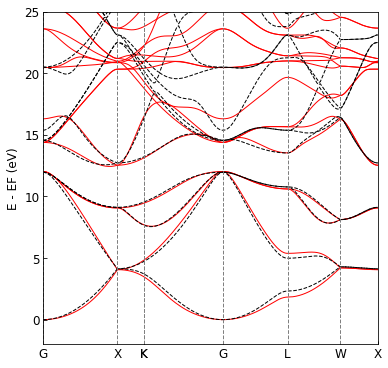

In [13]:
# plot the band structure w.r.t. DFT results
#band = np.load(f'./data/kpath.0/eigenvalues.npy')
band = np.load("./data/kpath.0/eigs.npy")

if len(band.shape)==3:
    band = band[0,:,:]
plt.figure(figsize=(6,6),dpi=72)
plt.plot(eigenstatus['xlist'], eigenstatus['eigenvalues']- np.min(eigenstatus['eigenvalues']), 'r-',lw=1)
plt.plot(eigenstatus['xlist'], band[:,:] - np.min(band[:,:]),'k--',lw=1)
plt.ylim(-2,25)

for ii in eigenstatus['high_sym_kpoints']:
    plt.axvline(ii,color='gray',lw=1,ls='--')
plt.tick_params(direction='in')

plt.xlim(eigenstatus['xlist'].min(),eigenstatus['xlist'].max())

plt.ylabel('E - EF (eV)',fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(eigenstatus['high_sym_kpoints'], eigenstatus['labels'], fontsize=12)
#plt.savefig(f'{self.results_path}/band.png',dpi=300)
plt.show()

In [12]:
np.abs(eigenstatus['eigenvalues'] - np.array([[-6.1745434 ,  5.282297  ,  5.282303  ,  5.2823052 ,  8.658317  ,
         8.6583185 ,  8.658324  ,  9.862869  , 14.152446  , 14.152451  ,
        15.180438  , 15.180452  , 16.983887  , 16.983889  , 16.983896  ,
        23.09491   , 23.094921  , 23.094925  ],
       [-5.5601606 ,  2.1920488 ,  3.4229636 ,  3.4229672 ,  7.347074  ,
         9.382092  , 11.1772175 , 11.177221  , 14.349099  , 14.924912  ,
        15.062427  , 15.064081  , 16.540335  , 16.54034   , 20.871534  ,
        20.871536  , 21.472364  , 28.740482  ],
       [-2.556269  , -2.5562677 ,  2.3915231 ,  2.391524  ,  6.4689007 ,
         6.468908  , 14.639398  , 14.6394005 , 14.734453  , 14.734456  ,
        14.747707  , 14.74771   , 15.57567   , 15.575676  , 17.403324  ,
        17.403334  , 38.39217   , 38.392174  ],
       [-2.6333795 , -2.367625  ,  1.6872846 ,  2.5042236 ,  6.6183453 ,
         7.9818068 , 13.933364  , 14.267717  , 14.706404  , 14.793142  ,
        14.841357  , 15.211192  , 15.578381  , 15.838447  , 17.168877  ,
        18.059359  , 35.321945  , 37.87687   ],
       [-2.9967206 , -1.8161079 ,  0.88636655,  2.829976  ,  7.0469265 ,
        10.600885  , 12.648353  , 13.126463  , 14.653016  , 14.841116  ,
        15.541919  , 15.576077  , 16.276308  , 16.574654  , 17.213411  ,
        19.315798  , 28.62305   , 35.468586  ],
       [-2.996724  , -1.8161156 ,  0.88636786,  2.8299737 ,  7.046927  ,
        10.600888  , 12.648361  , 13.126465  , 14.653028  , 14.841116  ,
        15.541907  , 15.5760765 , 16.276312  , 16.574644  , 17.21341   ,
        19.315798  , 28.623045  , 35.46858   ],
       [-5.471941  ,  1.5238439 ,  2.5368657 ,  4.577535  ,  8.749301  ,
         9.402245  , 10.557684  , 11.247256  , 14.576941  , 14.75164   ,
        14.775435  , 15.122616  , 17.103615  , 17.840292  , 18.390976  ,
        22.68788   , 23.806395  , 24.265633  ],
       [-6.1745434 ,  5.282297  ,  5.282303  ,  5.2823052 ,  8.658317  ,
         8.6583185 ,  8.658324  ,  9.862869  , 14.152446  , 14.152451  ,
        15.180438  , 15.180452  , 16.983887  , 16.983889  , 16.983896  ,
        23.09491   , 23.094921  , 23.094925  ],
       [-5.749872  ,  1.7248219 ,  4.5455103 ,  4.545513  ,  8.227031  ,
         9.438793  ,  9.4388    , 11.6675415 , 14.485937  , 14.485939  ,
        14.894153  , 14.894157  , 16.697474  , 16.697474  , 19.904425  ,
        23.02558   , 23.025585  , 23.831646  ],
       [-4.44458   , -1.6045983 ,  4.0464916 ,  4.046497  ,  7.2234683 ,
         9.777258  ,  9.777259  , 14.115966  , 14.4775715 , 14.4775715 ,
        14.98191   , 14.9819145 , 16.346727  , 16.346727  , 18.716038  ,
        23.819721  , 23.819735  , 27.016748  ],
       [-3.8950639 , -1.3644799 ,  1.8130541 ,  3.112887  ,  8.6044655 ,
         9.8463125 , 11.3755455 , 12.709737  , 14.566758  , 14.910749  ,
        15.183235  , 15.717886  , 16.694214  , 17.240337  , 19.386671  ,
        21.171314  , 23.601032  , 29.806623  ],
       [-2.3356187 , -2.3356178 ,  1.3771206 ,  1.3771234 , 10.240082  ,
        10.240085  , 12.212795  , 12.212798  , 14.746381  , 14.746386  ,
        15.778043  , 15.778048  , 15.790003  , 15.790005  , 18.402258  ,
        18.40226   , 31.99752   , 31.997526  ],
       [-2.4508858 , -2.4508843 ,  1.809629  ,  1.809632  ,  8.082377  ,
         8.082378  , 13.7137    , 13.713703  , 14.742302  , 14.742307  ,
        15.081548  , 15.081549  , 15.864478  , 15.864485  , 17.778458  ,
        17.77847   , 35.317     , 35.317005  ],
       [-2.556269  , -2.5562677 ,  2.3915231 ,  2.391524  ,  6.4689007 ,
         6.468908  , 14.639398  , 14.6394005 , 14.734453  , 14.734456  ,
        14.747707  , 14.74771   , 15.57567   , 15.575676  , 17.403324  ,
        17.403334  , 38.39217   , 38.392174  ]]))<1e-4

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],